<a href="https://colab.research.google.com/github/popelucha/NLP-notebooks/blob/main/Aspect_Based_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation Steps
Install Hugging Face `transformers` (BERT is not the only one transformer, you can experiment with others too) and `datasets` (again, you can experiment with other sentiment-analysis datasets). Install `sentence-splitter`.

We will define manually the "aspect words" and find them (and similar words) in the sentences. For similarity, we use word embeddings.



## More details

Aspect-based sentiment analysis makes sense in case of reviews, where the reviewer comments on several aspects (attributes) of the reviewed object. The sentiment polarity and intensity can be different for each aspect. Aspect-based sentiment analysis therefore provides more detailed insight into users' sentiments about the object than a simple 👍 or 👎 of the whole text.


The assumptions are:
* the text is structured in sentences
* the aspect is mentioned in the sentences together with the sentiment
* the sentiment analysis is performed in one domain, so the aspects are predefined (supervised)

In order to have the aspects definitions more robust, we accept semantically similar words too. For this task, we use the word embeddings. For simplicity, we use the GloVe 50 (a small predefined word embeddings model). You can experiment with larger models that probably provide more accurate synonyms.

## &nbsp;

In [ ]:
!pip install transformers datasets

In [ ]:
!pip install sentence-splitter

In [ ]:
!pip install gensim

In [ ]:
from datasets import load_dataset # load dataset stored in hugging face
from transformers import AutoModelForSequenceClassification # generalized task
from transformers import AutoTokenizer # the tokenizer has to be compatible with the model (so Auto* is a good choice)
from transformers import pipeline # pipeline for the whole task
import numpy as np
import gensim.downloader as api
from sentence_splitter import SentenceSplitter, split_text_into_sentences

In [ ]:
gv = api.load('glove-wiki-gigaword-50')

# Get the data
In this notebook, we experiment with movie reviews. The IMDB dataset provides overall sentiment as a binary classification (positive/negative).

**TASK1**: Observe the data, read some reviews, check the label. Do you agree with the label?

In [ ]:
imdb = load_dataset("imdb")

In [ ]:
id_ = 7900
imdb['test'][id_]

In [ ]:
text=imdb['test'][id_]['text']

In [ ]:
splitter = SentenceSplitter(language='en')
splitter.split(text=text)

# Pretrained Model for Sentiment Analysis

We will experiment with one of the Sentiment Analysis models available in Hugging Face collection.


## More details


The model is available in https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment.

Click on `Use in Transformers` to get the right class to `import`:
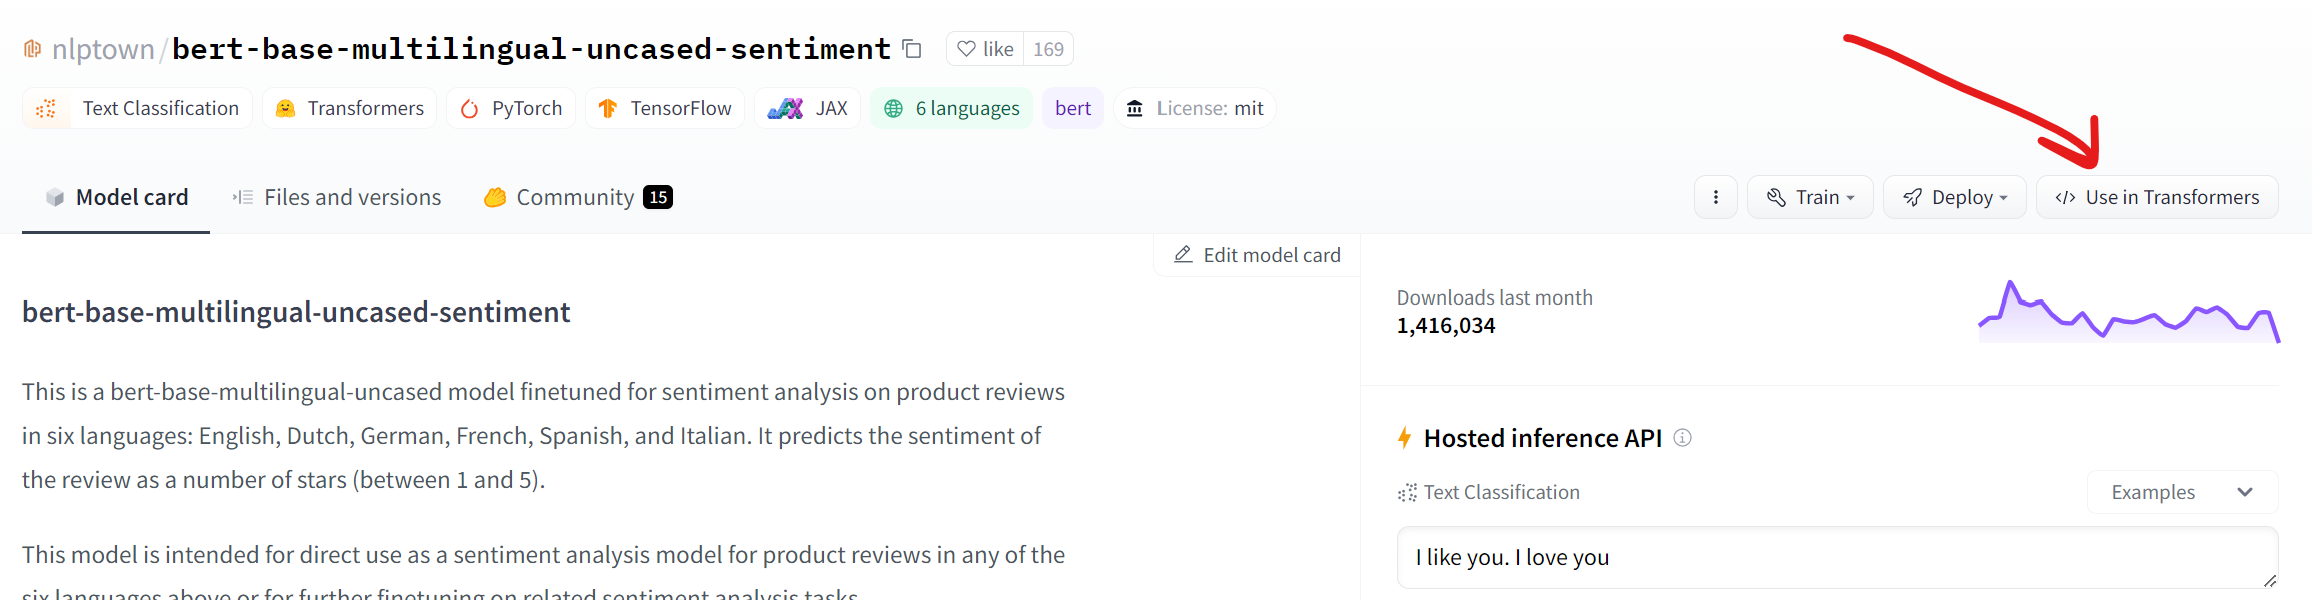

## &nbsp;

In [ ]:
model_name = 'sbcBI/sentiment_analysis'
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, **tokenizer_kwargs)

In [ ]:
classifier(text)

# Look for Aspects
First, we define manually the aspects relevant to the dataset.

Next, we use the BERT model to detect sentiment of each sentence. At the same time, if the aspect is mentioned in the sentence, we assume it is the sentiment towards the aspect.

**TASK2**: Go back to observed data and find some aspects the reviewers evaluate.

In [ ]:
aspects = {'actor': ['actor', 'actress'],
           'action': ['action']}

In [ ]:
def cosine(A, B):
  return np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))

In [ ]:
predicted_label = classifier(text)[0]['label']
print('Overall classification', predicted_label, imdb['test'][id_]['label'])
if (imdb['test'][id_]['label']==0 and predicted_label in ['1 star', '2 stars', '3 stars']) or (imdb['test'][id_]['label']==1 and predicted_label in ['4 stars', '5 stars']):
  print('True')
else:
  print('False')

In [ ]:
threshold = 0.8
splitter = SentenceSplitter(language='en')
absa = {}
for sentence in splitter.split(text=text):
#  print(sentence)
  for token in tokenizer.tokenize(sentence):
    for aspect_name, aspect_values in aspects.items():
      for aspect in aspect_values:
        if token in gv and aspect in gv:
          similarity = cosine(gv[aspect], gv[token])
          if similarity>threshold:
            if aspect_name not in absa.keys():
              absa[aspect_name] = []
            if token not in [t['token'] for t in absa[aspect_name]]:
              absa[aspect_name].append({'token': token, 'label': classifier(sentence)})
  #print(classifier(sentence))
print('Result')
absa

If you uncomment the texts, you will see sentiment classification for each sentence.

# Simple but Efficient?

So far, we did not measure whether this simple approach is good. Let's check on some aspect-based annotated data.

**TASK3**: Use part of the TripAdvisor data to evaluate whether our approach can detect the aspect and their polarity in the data.

**UPDATED 2023-09-19 based on feedback in the lecture**

The TripAdvisor dataset contains *ground truth* values not only for the overall sentiment but also for aspects of the hotel. The aspects are Service, Cleanliness, Value, Sleep Quality, Rooms, Location and maybe some others. The Overall is the overall evaluation.

The TripAdvisor review example is below:

```json
"Ratings": {
        "Service": "5",
        "Cleanliness": "5",
        "Overall": "5.0",
        "Value": "4",
        "Sleep Quality": "3",
        "Rooms": "3",
        "Location": "3"
      },
      "AuthorLocation": "Surrey, Canada",
      "Title": "“Service was Excellent”",
      "Author": "susan h",
      "ReviewID": "UR123992579",
      "Content": "This was a very clean hotel. Not fancy but served the purpose. The service from the employees however was FANTASTIC! I would recommend to anyone not looking for swanky but good clean room at a very reasonable rate.",
      "Date": "February 1, 2012"
```

1. download the TripAdvisor dataset (only the JSON part) from https://www.cs.virginia.edu/~hw5x/Data/LARA/TripAdvisor/, bunzip (`bunzip TripAdvisorJson.tar.bz2`), untar (`tar -xvf TripAdvisorJson.tar`)
1. pick **one json** file (20-60 ratings)
1. find aspect words for the domain and put them in the `aspects` dictionary (at least five from the `Ratings` except of the `Overall`). Your `aspects` dictionary will look like:
```python
aspects = {'Location': ['place', ...], 'Value': ['money', ...], ...}
```
1. process the JSON data using our approach - you will obtain the same aspects as in the TripAdvisor dataset
1. write down how many times the aspect was found (e.g. from 25 reviews, the aspect Location was found 14 times)
1. find in how many cases there was an agreement (exact match), optionally, check whether the sentiment was detected correctly (instead of stars, use 1-3 for negative and 4-5 for positive). For example, in 14 cases where the Location aspect was found, it was predicted correctly in 8 cases.
1. write the results for each aspect in the text file
1. iterate to find good aspect words and suitable word embedding threshold
1. submit the best result in the homework vault

Your submission will look like:
```txt
selected file: 123567.json (28 reviews)

aspects = {...}

aspects found in the reviews:
Location 15/28
Sleep Quality 3/28
...

exact match:
Location 13/15
Sleep Quality 0/3

However, I observed that ...

```


## Hints


* Modify the loop over sentences, tokens, and aspects in a function. Calculate rating for the aspect as the average of star evaluations.
* To convert the stars into the TripAdvisor rating, simply pick first character of the model prediction and convert it to `int` or `float`.
* If you increase the number of "aspect words", you increase the recall but the precision might drop.

## &nbsp;